In [7]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# PPO
## Double Q Learning (This is technically Double Q learning with a soft update)
# TD Learning (TD-Gammon)
# World Models


import os
import sys
from collections import namedtuple, deque, defaultdict
from typing import List, Tuple
from itertools import count

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym

print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
# torch.backends.cudnn.benchmark = False
# This is going to be necessary for perfect reproducibility
# print(os.environ["CUBLAS_WORKSPACE_CONFIG"])
# torch.use_deterministic_algorithms(True)

GPU Available: True


In [8]:
env = gym.make("CartPole-v1")
# env = gym.make("MountainCarContinuous-v0") # Box not supported
# env = gym.make("Acrobot-v1") # Sparse rewards.
# env = gym.make("MountainCar-v0") # Sparse rewards 

In [9]:
# Replay Memory 
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))


class ReplayMemory:
    def __init__(self, memory_capacity: int):
        self.mem_cap = memory_capacity
        self.reset_memory()
        
    def __len__(self):
        return len(self.memory)
    
    def reset_memory(self):
        self.memory = deque([], maxlen = self.mem_cap)
    
    def append(self, *args) -> None: 
        self.memory.append(Transition(*args))
        
    def sample(self, batchsize: int) -> List[Transition]:
        inds = np.random.choice(len(self.memory), batchsize)
        batch = [self.memory[ind] for ind in inds]
        return batch
    def clear(self):
        self.reset_memory()

In [10]:
class DQN(nn.Module):
    def __init__(self, n_obs, n_actions): 
        super(type(self), self).__init__()
        self.layer_size = 128
        self.n_hidden_layers = 1
        if self.n_hidden_layers < 0: 
            raise ValueError("Network must have at least 0 layers (input and output)")
            
        self.input_layer = nn.Linear(n_obs, self.layer_size)
        self.layers = [self.input_layer, nn.ReLU()]
        for _ in range(self.n_hidden_layers):
            self.layers.append(nn.Linear(self.layer_size, self.layer_size))
            self.layers.append(nn.ReLU())
        self.output_layer = nn.Linear(self.layer_size, n_actions)
        self.layers.append(self.output_layer)
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.net(x)

In [11]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = .999 #1000
TAU = 0.005
# TARGET_SYNC = 10
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
def select_action(net, state, eps_threshold):
    global steps_done
    sample = np.random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#         np.exp(-1. * steps_done / EPS_DECAY)
    eps_threshold *= EPS_DECAY
    steps_done += 1
    if sample > eps_threshold:
#         with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
        return net(state).max(1)[1].view(1, 1), eps_threshold
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), eps_threshold


def plot_means(values_t: torch.tensor, meanlen: int):
    # Take 100 episode averages and plot them too
    if len(values_t) >= meanlen:
        means = values_t.unfold(0, meanlen, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(meanlen - 1), means))
        plt.plot(means.numpy())
    
def plot_values(values, show_result=False, stop_episode=None):
    plt.figure(1)
    values_t = torch.tensor(values, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values_t.numpy())
    plot_means(values_t, 100)
#     plot_means(values_t, EARLY_STOP_MEANLEN)
    
    if stop_episode is not None: 
        plt.axvline(stop_episode, c = 'r')

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
        

Complete


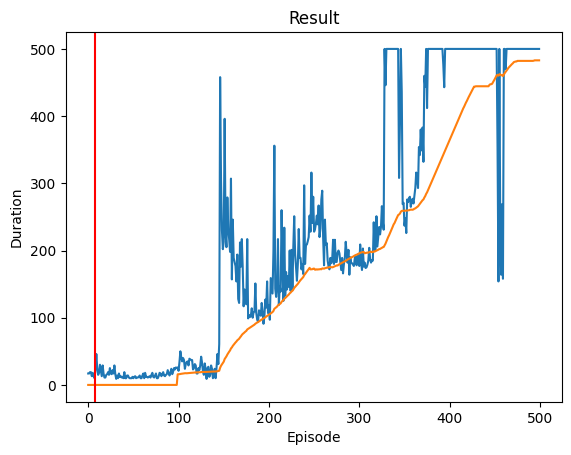

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
# Training
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    """
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    """
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Mine. 
    done_batch = torch.cat(batch.done)
    next_state_batch = torch.cat(batch.next_state)
    online_Q = policy_net(state_batch)
    online_values = online_Q.gather(1, action_batch) # Q(s, a)
    online_next_Q = policy_net(next_state_batch)
    best_action = torch.argmax(online_next_Q, axis = 1).unsqueeze(1) # a' for Q(s', -)
    bootstrap_Q = target_net(next_state_batch)
    bootstrap_values = bootstrap_Q.gather(1, best_action) 
    state_action_values = online_values
    expected_state_action_values = (bootstrap_values * (1 - done_batch.float()) * GAMMA) + reward_batch
    
    """
    # This should be off due to tensor shape changes now. See prev. 
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    """

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    assert state_action_values.shape == expected_state_action_values.shape
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    
    
    
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 50

early_stop = False
stop_episode = None
episode_durations = []
episode_rewards = []
exploration_rate = 1.0
memory.clear()
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    frame_count = 0
    total_reward = 0
    for t in count():
        action, exploration_rate = select_action(policy_net, state, exploration_rate)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([[reward]], device=device)
        done = terminated or truncated
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.append(state, action, next_state, reward, torch.tensor([[done]], device=device))
        if len(memory) > BATCH_SIZE and stop_episode is None: 
            stop_episode = i_episode
            
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        # Hard sync. 
#         if frame_count % TARGET_SYNC:
#             target_net.load_state_dict(policy_net.state_dict())
        
        
        #Perform one step of the optimization (on the policy network)
        optimize_model()
        
            
        # Move to the next state
        state = next_state



        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)
#             plot_values(episode_durations)
            plot_values(episode_rewards, stop_episode = stop_episode)
            break
        
if stop_episode is None: 
    stop_episode = num_episodes - 1
print('Complete')
plot_values(episode_rewards, show_result = True, stop_episode = stop_episode)

plt.show()

In [13]:
transitions = memory.sample(BATCH_SIZE)
batch = Transition(*zip(*transitions))
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

done_batch = torch.cat(batch.done)
next_state_batch = torch.cat(batch.next_state)

print(state_batch.shape, next_state_batch.shape, action_batch.shape, reward_batch.shape, done_batch.shape)

torch.Size([128, 4]) torch.Size([128, 4]) torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1])


In [14]:
# Broken
current_Q = policy_net(state_batch)[np.arange(0, state_batch.shape[0]), action_batch]
with torch.no_grad():
    next_state_Q_batch = policy_net(next_state_batch)
    best_action_batch = torch.argmax(next_state_Q_batch, axis=1)
    next_Q_batch = target_net(next_state_batch)[np.arange(0, next_state_batch.shape[0]), best_action_batch]
    state_action_values = current_Q
    expected_state_action_values = (reward_batch + GAMMA * (1 - done_batch.float()) * next_Q_batch).float()


In [15]:
# Fixing
current_Q = policy_net(state_batch).gather(1, action_batch)
with torch.no_grad():
    next_state_Q_batch = policy_net(next_state_batch) # Q(s', -)
    best_action_batch = torch.argmax(next_state_Q_batch, axis=1).unsqueeze(1) # a' for Q(s', -)
    next_Q_batch = target_net(next_state_batch).gather(1, best_action_batch) # Q_t(s', a')
    state_action_values = current_Q
    expected_state_action_values = (reward_batch + GAMMA * (1 - done_batch.float()) * next_Q_batch).float()
    
print(next_state_Q_batch.shape, best_action_batch.shape, state_action_values.shape, next_Q_batch.shape, expected_state_action_values.shape)

torch.Size([128, 2]) torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1])


In [16]:
# Working pre tensor shape change
state_action_values = policy_net(state_batch).gather(1, action_batch) # Q(s, a)
next_state_values = target_net(next_state_batch).max(1)[0] # Q_t(s', a') with maximizing a'
expected_state_action_values = (next_state_values * (1 - done_batch.float()) * GAMMA) + reward_batch

print(state_action_values.shape, next_state_values.shape, expected_state_action_values.shape)

# Post tensor shape change: Working = False
state_action_values = policy_net(state_batch).gather(1, action_batch) # Q(s, a)
next_state_values = target_net(next_state_batch).max(1)[0].unsqueeze(1) # Q_t(s', a') with maximizing a'
expected_state_action_values = (next_state_values * (1 - done_batch.float()) * GAMMA) + reward_batch

print(state_action_values.shape, next_state_values.shape, expected_state_action_values.shape)
state_action_values

torch.Size([128, 1]) torch.Size([128]) torch.Size([128, 128])
torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1])


tensor([[100.6098],
        [100.6654],
        [100.5918],
        [100.5925],
        [100.8049],
        [100.7340],
        [100.5805],
        [100.5964],
        [100.6331],
        [100.6482],
        [100.5971],
        [100.7846],
        [100.6651],
        [100.6003],
        [100.6429],
        [100.5925],
        [100.7827],
        [100.6345],
        [100.7175],
        [100.5536],
        [100.7997],
        [100.6217],
        [100.6648],
        [100.6697],
        [100.7596],
        [100.7705],
        [100.6794],
        [100.5973],
        [100.6292],
        [100.8307],
        [100.6182],
        [100.5985],
        [100.8208],
        [100.5946],
        [100.7286],
        [100.7259],
        [100.6435],
        [100.7106],
        [100.5680],
        [100.7660],
        [100.7925],
        [100.8911],
        [100.5586],
        [100.5842],
        [100.7156],
        [100.5824],
        [100.7451],
        [100.7099],
        [100.6451],
        [100.9137],


In [17]:
# From paper
cur_Q = policy_net(state_batch).gather(1, action_batch)
# Select action with online
next_state_action_values = policy_net(next_state_batch)
best_action = torch.argmax(next_state_action_values, axis = 1).unsqueeze(1)
# Bootstrap with target
next_Q = target_net(next_state_batch).gather(1, best_action)
expected_Q = reward_batch + (1 - done_batch.float()) * GAMMA * next_Q

print(cur_Q.shape, next_Q.shape, done_batch.shape, expected_Q.shape)

next_state_action_values

torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1])


tensor([[100.6176, 100.6066],
        [100.6385, 100.6410],
        [100.5803, 100.5805],
        [100.5979, 100.2385],
        [100.7917, 100.8168],
        [100.7104, 100.7318],
        [100.5354, 100.5924],
        [100.3096, 100.6002],
        [100.6042, 100.6333],
        [100.6435, 100.2222],
        [100.3018, 100.6104],
        [100.7479, 100.7545],
        [100.6385, 100.6578],
        [100.3003, 100.6096],
        [100.5974, 100.6175],
        [100.5914, 100.2105],
        [100.8175, 100.7952],
        [100.6069, 100.6648],
        [100.5471, 100.7222],
        [100.5197, 100.5603],
        [100.7726, 100.7761],
        [100.6153, 100.2671],
        [100.6225, 100.6989],
        [100.6455, 100.6598],
        [100.4086, 100.7361],
        [100.7713, 100.4028],
        [100.6741, 100.6271],
        [100.5934, 100.1986],
        [100.6135, 100.6425],
        [100.6773, 100.8363],
        [100.6125, 100.2884],
        [100.5861, 100.6013],
        [100.6507, 100.8192],
        [1

Complete


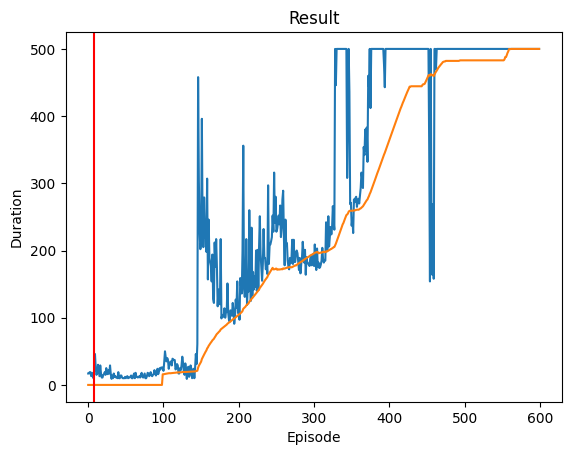

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 20

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action, _ = select_action(target_net, state, 0.0)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        # Move to the next state
        state = next_state

        if done:
            episode_rewards.append(total_reward)
            episode_durations.append(t + 1)
#             plot_values(episode_durations, stop_episode = stop_episode)
            plot_values(episode_rewards, stop_episode = stop_episode)
            break

print('Complete')
# plot_durations(episode_durations, show_result=True, stop_episode = stop_episode)
plot_values(episode_rewards, show_result = True, stop_episode = stop_episode)

plt.show()

In [19]:
plt.ioff()